# Evoluční algoritmy - spojitá optimalizace

Minule jsem si ukazovali jednoduchý genetický algoritmus, který pracoval s binárními jedinci. Dnes se podíváme na spojité reprezentace jedinců a na další druhy evolučních operátorů.

## Minimalizace Rastrigin funkce

V následujícím cvičení si vyzkoušíme napsat jednoduchý evoluční algoritmus pro minimalizaci [Rastrigin funkce](https://en.wikipedia.org/wiki/Rastrigin_function). Tato funkce je typickým příkladem nelineární funkce a běžně se používá při testování chování optimalizačních algoritmů. Nalezení jejího minima je složité, protože obsahuje spoustu lokálních minim. 



In [14]:
import random
import copy
import math

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Nejprve si definujeme, jak tedy vypadá ona výše zmíněná funkce, kterou budeme chtít minimalizovat. Potom je třeba si rozmyslet, jak bude vypadat jedinec. Pro nás to teď bude floating point vektor, kde hodnoty budou čísla z intervalu [-5.12,5.12]. Pro něj si napíšeme svoje operátory křížení a mutace. Křížení může být aritmetické, například vážený průměr dvou jedinců, nebo strukturální, kdy opět prohazujeme části jedinců. Mutace může být buď nezatížená (unbiased), což znamená, že se pro mutovanou pozici vygeneruje nové číslo uniformě z daného rozsahu hodnot, nebo zatížená (biased), kdy k hodnotě v jedinci přičtu nějaké číslo z normálního rozdělení s danou odchylkou (například 1) a nulovou střední hodnotou.

In [15]:
# Value of a fitness function will be the value of Rastrigin function in the given point
# But we want to change minimization of the function to maximization of the fitness, thus we return minus the value
def fitness(individual):
    N = len(individual)
    A = 10
    
    value = A * N
    for i in range(len(individual)):
        value += (individual[i] * individual[i]) - A * math.cos(2 * math.pi * individual[i])
        
    return -value


# Unbiased mutation
def mutation_unbiased(population, individual_mutation_prob=0.2, value_mutation_prob=0.1):
    new_population = []
    
    for i in range(len(population)):
        individual = population[i]
        
        if random.random() < individual_mutation_prob:
            individual = copy.deepcopy(individual)
            
            for i in range(len(individual)):
                if random.random() < value_mutation_prob:
                    individual[i] = np.random.uniform(-5.12, 5.12)
                    
        new_population.append(individual)
        
    return new_population


# Arithmetic crossover
def crossover_arithmetic(population, cross_prob=0.8, alpha=0.25):
    new_population = []
    
    for i in range(len(population)//2):
        individual1 = population[2*i]
        individual2 = population[2*i+1]
        
        if random.random() < cross_prob:
            # Either, we could do this bit by bit like this (which is quite slow):
            # child1 = copy.deepcopy(individual1)
            # child2 = copy.deepcopy(individual2)
            #
            # for i in range(len(individual1)):
            #     child1[i] = alpha * individual1[i] + (1-alpha) * individual2[i]
            #     child2[i] = (1-alpha) * individual1[i] + alpha * individual2[i]
            
            # Or we can take advantage of the fact we are using NumPy arrays, like this:
            # (The sum of arrays returns a new array, so there is no need for the deepcopy)
            child1 = alpha * individual1 + (1-alpha) * individual2
            child2 = (1-alpha) * individual1 + alpha * individual2
                
        else:
            child1 = individual1
            child2 = individual2
                
        new_population.append(child1)
        new_population.append(child2)
        
    return new_population


# Population intialization (random)
def random_population(population_size, individual_size):
    return list(np.random.uniform(-5.12, 5.12, size=(population_size, individual_size)))


# Tournament selection
def tournament_selection(population, fitness_value, k): 
    new_population = []
    
    for _ in range(len(population)):
        indices = np.random.choice(len(population), size=k, replace=False)
        individuals = [population[idx] for idx in indices]
        fitnesses = [fitness_value[idx] for idx in indices]
            
        new_population.append(individuals[np.argmax(fitnesses)])
        
    return new_population 

Nyní si stejně jako v minulé hodině definujeme celý evoluční algoritmus a pak ho pustíme a sledujeme, co se bude dít.

In [16]:
def evolution(population_size, individual_size, max_generations):
    max_fitness = []
    population = random_population(population_size,individual_size)
    
    for _ in range(max_generations):
        fitness_value = list(map(fitness, population))
        max_fitness.append(max(fitness_value))
        
        parents = tournament_selection(population, fitness_value, 2)
        children = crossover_arithmetic(parents)
        mutated_children = mutation_unbiased(children)
        
        population = mutated_children
        
    # We compute fitness for the last population and obtain the best individual
    fitness_value = list(map(fitness, population))
    max_fitness.append(max(fitness_value))
    best_individual = population[np.argmax(fitness_value)]
    
    return best_individual, population, max_fitness

Best fitness: -8.715815089639108
Best individual: [ 0.00433486  0.05143977 -0.01115742 -0.05340447 -0.91366215 -0.00257095
  0.0389731   1.01734716 -0.95468212  1.0866436 ]


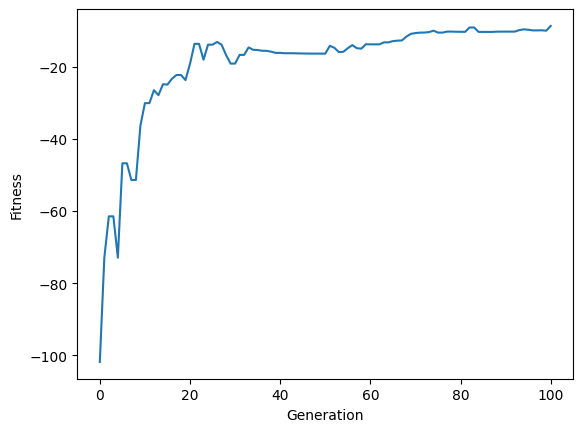

In [17]:
best, population, max_fitness = evolution(population_size=100, individual_size=10, max_generations=100)

print("Best fitness:", fitness(best))
print("Best individual:", best)


plt.plot(max_fitness)
plt.ylabel("Fitness")
plt.xlabel("Generation")
plt.show()


## Úkol na cvičení

V kódu výše je naprogramovaná nejjednodušší mutace - nezatížená. Zkuste si napsat alespoň dva další druhy mutace z následujích možností a porovnat, jak se bude evoluční algoritmus chovat.
1. Zatížená mutace, kdy se k hodnotě v jedinci přičítá číslo z normalního rozdělení se střední hodnotou 0 a rozptylem sigma. Sigma se třeba navíc může během každých n generací postupně snižovat. 

2. Mutace s 1/5 pravidlem, která se používá hlavně u evolučních strategií a probíhá podobně jako zatížená mutace - přičítá k hodnotě číslo z náhodného rozdělení se střední hodnotou 0 a rozptylem sigma. Sigma se updatuje v každém kroku následovně: Při každé mutaci se podívám, jestli je výsledný jedinec lepší, než co jsem měl před mutací. Pokud ano, říkám, že je mutace úspěšná. V průběhu celé iterace si zapamatuji poměr úspěšných mutací *p* (tedy počet úspěšných mutací ku počtu všech mutací). Sigmu pak upravíme pomocí jednoduché rovnice: sigma = sigma \* e^(*p*-1/5). \
(Ergo pokud jsem v této iteraci nageneroval mutací víc jak pětinu jedinců takovou, že jsou lepší než jedinci, které jsem už měl před mutací, sigma se zvýší (-> vyšší explorace), jinak se sigma sníží (-> vyšší exploitace).)

3. Mutace z diferenciální evoluce, která vybere náhodně pro daného jedince dva další, dělá rozdíl jejich hodnot (složku po složce) a ten navíc vynásobí nějakou konstantou (třeba 0.8) a to pak přičte k hodnotám v původním jedinci.

Můžete samozřejmě zkusit vymyslet i nějakou vlastní mutaci, nebo třeba zkusit vypnout mutaci nebo vypnout křížení a sledovat, co se bude s evolucí dít.

## Deap knihovna

Nyní si opět vyzkoušíme přepsat výše zmíněný problém minimalizace Rastrigin funkce pomocí operátorů knihovny DEAP, abychom si lépe vyzkoušeli, jak se s ní pracuje a jak v ní tvořit svoje vlastní operátory, které se nám budou hodit příští hodinu u genetického programování.

In [18]:
from deap import algorithms, base, creator, tools

Pro jistotu si znovu definujeme vlastní funkce mutace, křížení a fitness funkci.

In [19]:
def rastring_function(individual):
    N = len(individual)
    A = 10
    
    value = A * N
    for i in range(len(individual)):
        value += (individual[i] * individual[i]) - A * math.cos(2 * math.pi * individual[i])
        
    return value,


def mutation_unbiased(individual, value_mutation_prob):
    for i in range(len(individual)):
        if random.random() < value_mutation_prob:
            individual[i] = np.random.uniform(-5.12, 5.12)
            
    return individual,


def crossover_arithmetic(individual1, individual2, alpha=0.25):
    # We will be working with python lists, so we cannot use the NumPy hack we used before and must do this bit by bit
    child1 = copy.deepcopy(individual1)
    child2 = copy.deepcopy(individual2)
    
    for i in range(len(individual1)):
        child1[i] = alpha * individual1[i] + (1-alpha) * individual2[i]
        child2[i] = (1-alpha) * individual1[i] + alpha * individual2[i]
        
    return child1, child2

Pak si zadefinujeme nový toolbox a přídáme do něj naše operátory. 

In [20]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # -1 because we want to minimize the function
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

toolbox.register("attr_float", random.uniform, -5.12, 5.12)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=4)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", rastring_function)
toolbox.register("mate", crossover_arithmetic)
toolbox.register("mutate", mutation_unbiased, value_mutation_prob=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)


Na závěr pustíme celou evaluci a můžeme sledovat, jak se nám hledání minima daří, nebo případně nedaří.

In [21]:
pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.8, mutpb=0.2, ngen=100, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg    	std    	min    	max    
0  	300   	74.8046	20.5047	19.2884	143.182
1  	243   	57.1818	17.0982	17.3905	112.608
2  	244   	47.6543	15.2048	5.46991	101.153
3  	249   	44.5244	14.4508	8.75004	87.848 
4  	243   	39.9323	14.2641	6.17808	77.8516
5  	264   	41.0304	15.1635	9.62372	82.302 
6  	260   	37.4672	13.4722	9.19985	77.9514
7  	252   	33.9602	14.9166	4.0724 	76.6245
8  	252   	29.1861	14.3952	1.32765	88.5183
9  	255   	25.4248	13.0605	2.34145	81.2413
10 	270   	21.8669	12.2203	1.86463	76.8517
11 	251   	15.6515	10.7227	1.4944 	57.3964
12 	257   	10.1071	9.38657	1.03348	58.7766
13 	253   	5.66114	7.96127	0.518558	64.2026
14 	255   	3.34548	7.51056	0.441648	82.805 
15 	256   	2.59888	6.64623	0.25191 	40.6942
16 	252   	2.28758	7.06916	0.15803 	62.4101
17 	253   	2.7699 	8.07922	0.0823215	56.4053
18 	246   	1.83624	6.58838	0.0799304	39.4051
19 	238   	1.52926	6.63294	0.0673678	61.1285
20 	241   	1.70411	7.30921	0.071461 	57.9935
21 	248   	1.70238	6.50914	0.0770755	51.49